# Setup
Loading all the necessary libraries.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

from statsmodels.sandbox.stats.runs import runstest_1samp
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import acf

import os
import re
from scipy import ndimage
import math
import random
import cv2
import skimage
from scipy import stats
import pylab

from PIL import Image, ImageEnhance
from skimage.measure import label, regionprops
from skimage.io import imsave
from skimage.filters import threshold_otsu

# Helper functions
Here we define the functions that we later use in the proceeding of the notebook.  
You can find here the `img_info_to_part_id` and `rotate_and_crop` functions cited in the report. 

In [13]:
def img_info_to_part_id(imgname, location):
	imgid = int(re.search(r"img(\d+)\.bmp", imgname).group(1))
	if location == "top_left":
		return (imgid - 1) * 4
	elif location == "bottom_left":
		return (imgid - 1) * 4 + 1
	elif location == "top_right":
		return (imgid - 1) * 4 + 2
	elif location == "bottom_right":
		return (imgid - 1) * 4 + 3
	else:
		raise ValueError("Invalid location: {}".format(location))

# example
print(img_info_to_part_id("img01.bmp", "top_left"))
print(img_info_to_part_id("img01.bmp", "bottom_left"))
print(img_info_to_part_id("img01.bmp", "top_right"))
print(img_info_to_part_id("img01.bmp", "bottom_right"))
print()
print(img_info_to_part_id("img02.bmp", "top_left"))
print(img_info_to_part_id("img02.bmp", "bottom_left"))
print(img_info_to_part_id("img02.bmp", "top_right"))
print(img_info_to_part_id("img02.bmp", "bottom_right"))

0
1
2
3

4
5
6
7


In [14]:
def part_id_to_img_info(part_id):
	pid_copy = part_id
	while pid_copy % 4 != 0:
		pid_copy -= 1
	imgnum = pid_copy // 4 +1 
	imgnum = "{:02d}".format(imgnum)

	if part_id % 4 == 0:
		location = "top_left"
	elif part_id % 4 == 1:
		location = "bottom_left"
	elif part_id % 4 == 2:
		location = "top_right"
	elif part_id % 4 == 3:
		location = "bottom_right"
	else:
		raise ValueError("Invalid part ID: {}".format(part_id))

	return imgnum, location

# example
print(part_id_to_img_info(0))
print(part_id_to_img_info(1))
print(part_id_to_img_info(2))
print(part_id_to_img_info(3))
print()
print(part_id_to_img_info(4))
print(part_id_to_img_info(5))
print(part_id_to_img_info(6))
print(part_id_to_img_info(7))

('01', 'top_left')
('01', 'bottom_left')
('01', 'top_right')
('01', 'bottom_right')

('02', 'top_left')
('02', 'bottom_left')
('02', 'top_right')
('02', 'bottom_right')


In [22]:
cartella_immagini = {
	'originals': './Processed dataset/df old/',
	'rot&crop': './Processed dataset/df new/',
	# other possible folders
}

# in english: generate_image_path
def genera_percorso_immagine(part_id, which_ones="originals",option="seg"):	
	imgnum, location = part_id_to_img_info(part_id)
	real_option = option
	if option=="seg":
		real_option = "segmented"
	else:
		real_option = "labeled"

	nome_immagine = f"img{imgnum}.bmp_{location}_{real_option}.png"
	return os.path.join(cartella_immagini[which_ones], nome_immagine)

# Utilizzo della funzione
print(genera_percorso_immagine(0, "originals"))
print(genera_percorso_immagine(1, "originals"))
print(genera_percorso_immagine(2, "originals"))
print(genera_percorso_immagine(3, "originals"))

./Processed dataset/df old/img01.bmp_top_left_segmented.png
./Processed dataset/df old/img01.bmp_bottom_left_segmented.png
./Processed dataset/df old/img01.bmp_top_right_segmented.png
./Processed dataset/df old/img01.bmp_bottom_right_segmented.png


In [16]:
def rotate_and_crop(img, rect, verbose=0):
	# get params
	center, size, angle = rect[0], rect[1], rect[2]
	
	if angle > 45:
		angle = angle - 90
	if verbose == 1:
		print(f"Angle inside function is {angle}")
	
	center, size = tuple(map(int, center)), tuple(map(int, size))
	if verbose==1:
		print(rect)
		print(center)
		print(size)
	# get row and col num in img
	height, width = img.shape[0], img.shape[1]
	# rotation matrix
	M = cv2.getRotationMatrix2D(center, angle, 1)
	# apply rotation
	img_rot = cv2.warpAffine(img, M, (width, height))
	# crop it
	img_crop = cv2.getRectSubPix(img_rot, size, center)

	return img_crop, img_rot

In [17]:
def calculate_curvature(points):
	# Calcola la differenza delle coordinate x e y tra i punti successivi e precedenti
	dx = np.gradient(points[:, 0])
	dy = np.gradient(points[:, 1])

	# Calcola la seconda differenza delle coordinate x e y
	d2x = np.gradient(dx)
	d2y = np.gradient(dy)

	# Calcola la curvatura utilizzando la formula di curvatura
	curvature = (d2x * dy - d2y * dx) / (dx**2 + dy**2)**1.5

	return curvature

In [18]:
def summary_assumptions(data_points,titolo=""):
	plt.figure(figsize=(12,4))
	plt.subplot(1, 3, 1)
	stats.probplot(data_points,plot=plt)
	plt.subplot(1, 3, 2)
	plt.hist(data_points)
	plt.subplot(1, 3, 3)
	plt.plot(data_points,'o-')
	plt.suptitle(f"{titolo}")
	plt.show()
	_, shapiro_pvalue = stats.shapiro(data_points)
	print(f"({titolo}) Normality p-value = {shapiro_pvalue} - Normality at alpha 5%? {shapiro_pvalue>0.05}")
	_, pval_runs = runstest_1samp(data_points, correction=False)
	print(f'({titolo}) Runs test p-value = {pval_runs} - Random data at alpha 5%? {pval_runs>0.05}')

# Dataset manipulation

In [8]:
# call original python script
%run image_analysis_function.py

## df old

In [23]:
df_old = pd.read_csv('./Processed dataset/df old/image_statistics.csv')

# add 'Part_ID' using img_info_to_part_id
df_old['Part_ID'] = df_old.apply(lambda row: img_info_to_part_id(row['Image name'], row['Position']), axis=1)
# add 'Num_voids' using group by
df_old['Num_voids'] = df_old.groupby('Part_ID')['ID'].transform('max')

# parts and voids split
df_old_parts = df_old[df_old['Region type'] == 'part']
df_old_voids = df_old[df_old['Region type'] == 'void']

df_old.head(10)

,Image name,Position,Region type,ID,Area [pixels],Perimeter [pixels],Eccentricity,Orientation [radians],Solidity,Extent,Major Axis Length [pixels],Minor Axis Length [pixels],Equivalent Diameter [pixels],Part_ID,Num_voids
0,img01.bmp,top_left,part,0,39334,3979.892,0.145,-1.399,0.775,0.658,276.941,274.023,223.789,0,41
1,img01.bmp,top_left,void,1,94,37.556,0.773,1.445,0.949,0.696,14.463,9.178,10.940,0,41
2,img01.bmp,top_left,void,2,95,46.142,0.935,-1.466,0.872,0.565,19.647,6.959,10.998,0,41
3,img01.bmp,top_left,void,3,239,77.527,0.942,-1.432,0.909,0.569,31.984,10.699,17.444,0,41
4,img01.bmp,top_left,void,4,195,61.420,0.885,1.545,0.907,0.577,24.535,11.419,15.757,0,41
5,img01.bmp,top_left,void,5,146,54.770,0.883,0.818,0.912,0.477,20.885,9.814,13.634,0,41
6,img01.bmp,top_left,void,6,192,71.835,0.954,-1.440,0.881,0.529,30.397,9.124,15.635,0,41
7,img01.bmp,top_left,void,7,322,72.770,0.324,0.429,0.947,0.610,22.009,20.826,20.248,0,41
8,img01.bmp,top_left,void,8,342,76.184,0.498,0.893,0.927,0.594,23.752,20.593,20.867,0,41
9,img01.bmp,top_left,void,9,292,78.912,0.904,-0.973,0.927,0.438,31.198,13.312,19.282,0,41


## df_new

In [66]:
output_folder = "./Processed dataset/df new/"
statistics = []

for part_id in range(0,40):
	img = cv2.imread(genera_percorso_immagine(part_id, "originals"))

	# Converti l'immagine in scala di grigi
	gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
	# Applica il filtro bilaterale per ridurre il rumore
	blurred_img = cv2.bilateralFilter(gray, 10, 100, 100)
	# maybe blurred not really needed
	# decide it in the img input to the next function (choose gray or blurred_img)

	# Applica la binarizzazione Otsu
	(T, threshInv) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

	# Apply the Canny filter to detect edges
	edged = cv2.Canny(threshInv, 30, 200)

	# Find the contours
	contours, hierarchy = cv2.findContours(edged, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)

	# Select the biggest contour
	largest_contours = sorted(contours, key=cv2.contourArea, reverse=True)[:1]

	# crop the pictures following the biggest contour
	for i, contours in enumerate (largest_contours):
		rect = cv2.minAreaRect(contours)
		box = cv2.boxPoints(rect)
		box = np.int0(box)
		cropped_image, rot_image = rotate_and_crop(img, rect, verbose=0)

		img_info = part_id_to_img_info(part_id)
		filename = f"img{img_info[0]}.bmp_{img_info[1]}_segmented.png"
		cv2.imwrite(os.path.join(output_folder, filename), cropped_image) 

		# print(type(cropped_image))
		# plt.figure(figsize=(12, 12))
		# plt.subplot(1,3,1)
		# plt.imshow(cropped_image)
		# plt.axis('off')
		# plt.title("cropped_image")

		# img_pil = Image.fromarray(cropped_image, 'RGB')
		# img_pil = img_pil.convert('L')
		# print(type(img_pil))
		# plt.imshow(img_pil,cmap="gray")
		# plt.axis('off')
		# plt.show()

		# gray = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
		# (T, threshInv) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
		# labeled_segmented_image = label(threshInv)
	
		image = Image.open(os.path.join(output_folder, filename))
		# Convert the image to grayscale
		image = image.convert('L')
		# # Increase the contrast
		enhancer = ImageEnhance.Contrast(image)
		image = enhancer.enhance(100)
		# width, height = image.size
		# image = image.crop((0,0,width,height))
		image = np.array(image)
		# plt.imshow(image, cmap='gray')
		# plt.axis('off')  # Nasconde gli assi
		# plt.show()
		otsu_thresh = threshold_otsu(image)
		image = image > otsu_thresh

		# Convert the boolean image to an 8-bit unsigned integer image
		# img = (threshInv.astype(np.uint8) * 255)
		img = (image.astype(np.uint8) * 255)
		# Use regionprops to get properties of the region
		part_props = regionprops(img)[0]  # Get the first (and only) region
		# Crop the image with margin around the bounding box
		minr, minc, maxr, maxc = part_props.bbox
		# print(part_props.bbox)
		minr_crop = max(minr + 12, 0)
		minc_crop = max(minc + 12, 0)
		maxr_crop = min(maxr - 12, img.shape[0])
		maxc_crop = min(maxc - 12, img.shape[1])
		padded_img = img[minr_crop:maxr_crop, minc_crop:maxc_crop]
		
		# Invert the padded image
		inv_padded_img = 255 - padded_img
		# plt.subplot(1,3,2)
		# plt.imshow(inv_padded_img,cmap="gray")
		# plt.axis('off')
		# plt.title("inv_padded_img")

		# Apply labeling
		labels = label(inv_padded_img, background=0)
		# props_voids = regionprops(labels)
		# Find the biggest region
		# biggest_region = max(props_voids, key=lambda region: region.area)
		# Set the pixels in the biggest region to 0
		# labels[labels == biggest_region.label] = 0
		# Repeat labeling
		# labels = label(labels, background=0)
		props_voids = regionprops(labels)
		# Create a figure and axes
		plt.figure(figsize=(8, 8))
		fig, ax = plt.subplots()
		# Display the image
		ax.imshow(labels, cmap='nipy_spectral')
		# Annotate label numbers

		for region in regionprops(labels):
			# Get the coordinates of the centroid
			y, x = region.centroid
			# Annotate the label number at the centroid
			ax.text(x, y, str(region.label), color='white')
		# Save the labeled image  		
		labeled_filename = f"img{img_info[0]}.bmp_{img_info[1]}_labeled.png"
		labeled_output_path = os.path.join(output_folder, labeled_filename)
		plt.savefig(labeled_output_path)
		# Close the figure to free up memory
		# plt.show()
		# plt.close()
		plt.close('all')


		# For each statistic in regionprops, create a row with Image name, Position, Region type, ID, and each metric
		statistics.append({
			"Image name": f"img{img_info[0]}.bmp",
			"Position": img_info[1],
			"Region type": "part",
			"ID": 0,
			"Area [pixels]": round(part_props.area, 3),
			"Perimeter [pixels]": round(part_props.perimeter, 3),
			"Eccentricity": round(part_props.eccentricity, 3),
			"Orientation [radians]": round(part_props.orientation, 3),
			"Solidity": round(part_props.solidity, 3),
			"Extent": round(part_props.extent, 3),
			"Major Axis Length [pixels]": round(part_props.major_axis_length, 3),
			"Minor Axis Length [pixels]": round(part_props.minor_axis_length, 3),
			"Equivalent Diameter [pixels]": round(part_props.equivalent_diameter, 3),
			"Part_ID": part_id,
			"Num_voids": len(props_voids)
		})

		old_size = len(statistics)
		# print(f"Old size: {len(statistics)}")

		# Loop over each void
		for i, prop in enumerate(props_voids, start=1):
			# For each statistic in regionprops, create a row with Image name, Position, Region type, ID, and each metric
			statistics.append({
				"Image name": f"img{img_info[0]}.bmp",
				"Position": img_info[1],
				"Region type": "void",
				"ID": i,
				"Area [pixels]": round(prop.area, 3),
				"Perimeter [pixels]": round(prop.perimeter, 3),
				"Eccentricity": round(prop.eccentricity, 3),
				"Orientation [radians]": round(prop.orientation, 3),
				"Solidity": round(prop.solidity, 3),
				"Extent": round(prop.extent, 3),
				"Major Axis Length [pixels]": round(prop.major_axis_length, 3),
				"Minor Axis Length [pixels]": round(prop.minor_axis_length, 3),
				"Equivalent Diameter [pixels]": round(prop.equivalent_diameter, 3),
				"Part_ID": part_id,
				"Num_voids": len(props_voids)
			})

		# print(f"Nvoids from props: {len(props_voids)}")
		# print(f"Rows added now: {len(statistics)-old_size}")
		# print(f"Nvoids in df old were: {df_old_parts.iloc[part_id]['Num_voids']}\n")
		if (len(statistics)-old_size) != len(props_voids):
			print("Something strange happened")
			break

# Convert the list of dictionaries to a DataFrame
statistics_df = pd.DataFrame(statistics)
# Export the DataFrame to a CSV file in the output_folder
output_file = os.path.join(output_folder, "image_statistics.csv")
statistics_df.to_csv(output_file, index=False)

In [68]:
df_new = pd.read_csv('./Processed dataset/df new/image_statistics.csv')

# add 'Part_ID' using img_info_to_part_id
df_new['Part_ID'] = df_new.apply(lambda row: img_info_to_part_id(row['Image name'], row['Position']), axis=1)
# add 'Num_voids' using group by
df_new['Num_voids'] = df_new.groupby('Part_ID')['ID'].transform('max')

# parts and voids split
df_new_parts = df_new[df_new['Region type'] == 'part']
df_new_voids = df_new[df_new['Region type'] == 'void']

df_new.head(10)

,Image name,Position,Region type,ID,Area [pixels],Perimeter [pixels],Eccentricity,Orientation [radians],Solidity,Extent,Major Axis Length [pixels],Minor Axis Length [pixels],Equivalent Diameter [pixels],Part_ID,Num_voids
0,img01.bmp,top_left,part,0,38291,4105.674,0.153,-1.268,0.760,0.743,277.925,274.667,220.802,0,41
1,img01.bmp,top_left,void,1,104,40.142,0.752,-1.556,0.912,0.693,14.874,9.809,11.507,0,41
2,img01.bmp,top_left,void,2,106,47.799,0.935,-1.335,0.898,0.589,20.548,7.293,11.617,0,41
3,img01.bmp,top_left,void,3,263,80.355,0.939,-1.307,0.895,0.501,32.887,11.318,18.299,0,41
4,img01.bmp,top_left,void,4,211,64.006,0.884,-1.478,0.887,0.601,25.354,11.839,16.391,0,41
5,img01.bmp,top_left,void,5,159,56.355,0.874,0.932,0.888,0.523,21.442,10.408,14.228,0,41
6,img01.bmp,top_left,void,6,211,73.077,0.951,-1.313,0.847,0.471,31.267,9.708,16.391,0,41
7,img01.bmp,top_left,void,7,339,75.841,0.326,0.692,0.929,0.589,22.505,21.278,20.776,0,41
8,img01.bmp,top_left,void,8,361,78.184,0.502,1.001,0.928,0.602,24.343,21.051,21.439,0,41
9,img01.bmp,top_left,void,9,329,77.770,0.718,0.249,0.901,0.580,26.044,18.126,20.467,0,41


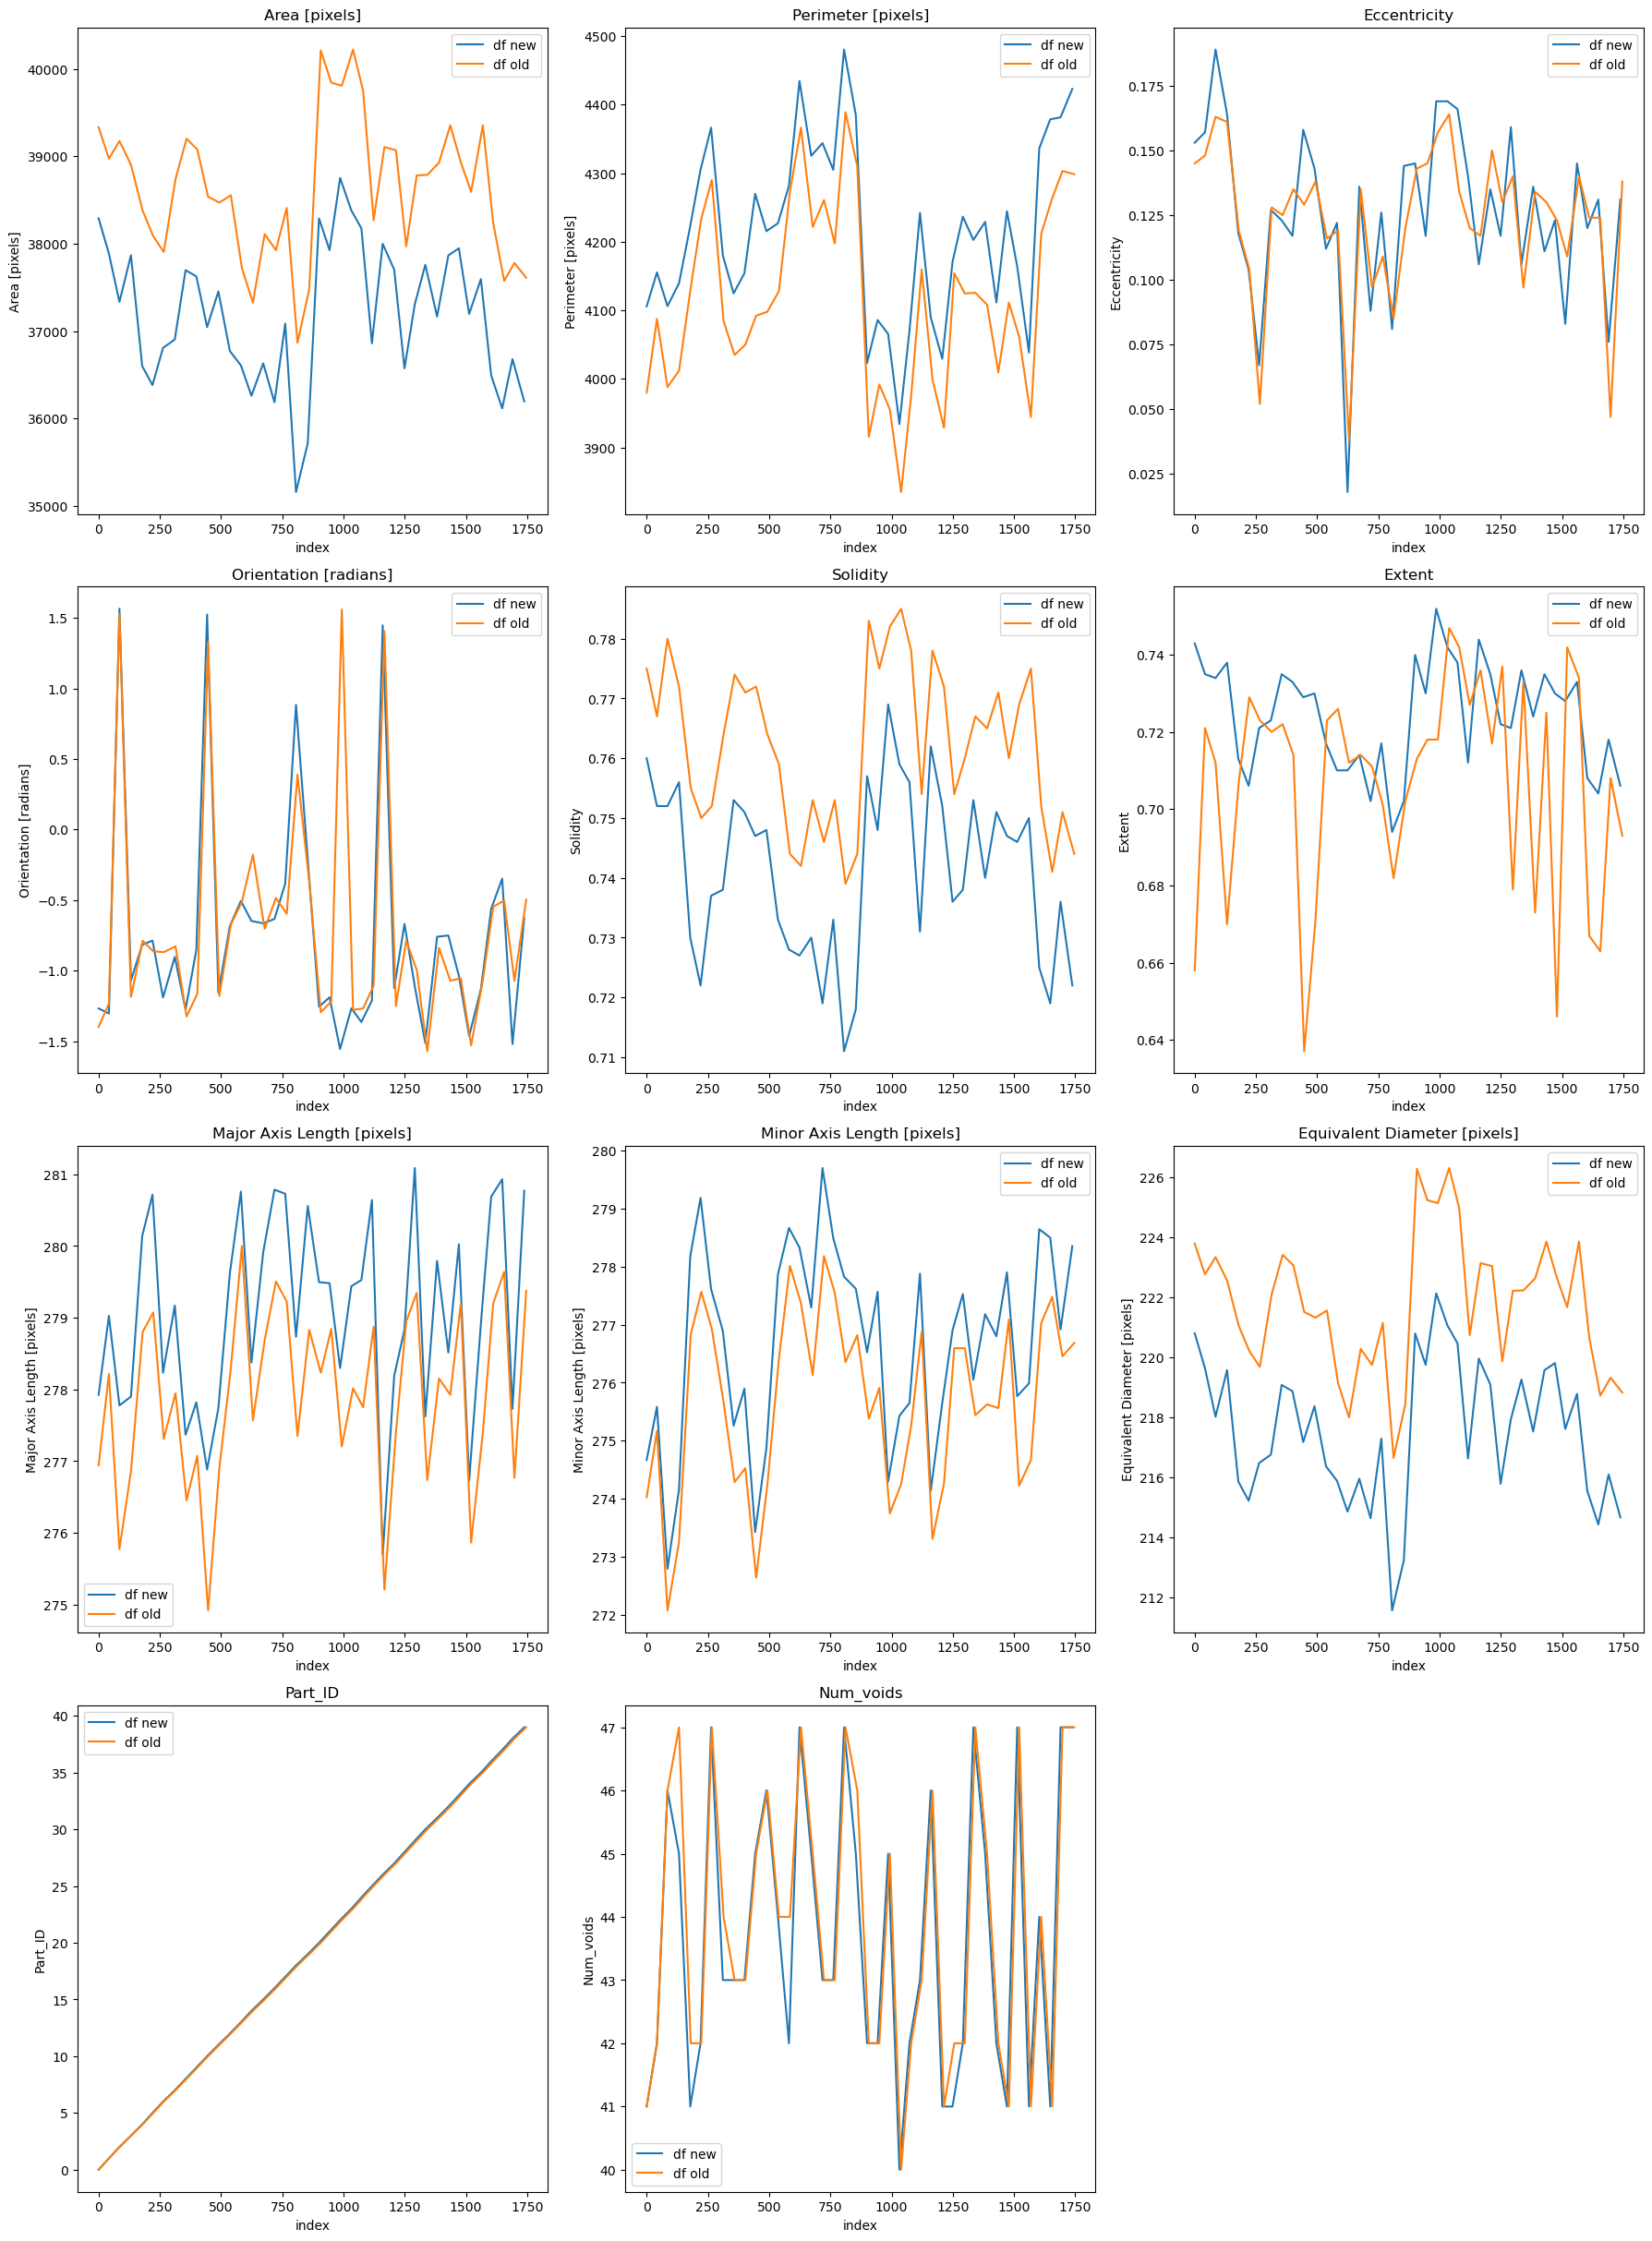

In [80]:
meaningful_cols = len(df_new_parts.columns[4:])
num_rows = meaningful_cols // 3 + meaningful_cols % 3  # Calcola il numero di righe necessarie per i subplot

fig, axes = plt.subplots(num_rows, 3, figsize=(18, 6*num_rows))  # Crea i subplot

for i, column in enumerate(df_new_parts.columns[4:]):
	row_index = i // 3
	col_index = i % 3

	axes[row_index, col_index].plot(df_new_parts[column], label='df new')
	axes[row_index, col_index].plot(df_old_parts[column], label='df old')

	axes[row_index, col_index].set_title(column)
	axes[row_index, col_index].set_xlabel('index')
	axes[row_index, col_index].set_ylabel(column)
	axes[row_index, col_index].legend()

fig.delaxes(axes[num_rows - 1, meaningful_cols % 3])
fig.delaxes(axes[num_rows - 2, meaningful_cols % 3])
fig.delaxes(axes[num_rows - 1, meaningful_cols % 3-1])
fig.delaxes(axes[num_rows - 1, meaningful_cols % 3-2])
plt.tight_layout()
plt.show()

In [65]:
df_old_parts.shape
df_new_parts.shape

(2, 15)